### aim to predict the escalation of users using lstm and compare with other baseline classfiers

In [71]:
import os
import sys
import git
import pickle

In [72]:
## Read the labelled files and the poly_user
def get_git_root(path):
	git_repo = git.Repo(path, search_parent_directories=True)
	git_root = git_repo.git.rev_parse("--show-toplevel")
	return git_root

In [73]:
top_dir = os.path.join(get_git_root(os.getcwd()))
input_dir = os.path.join(get_git_root(os.getcwd()),"input")
embeddings_dir  = os.path.join(get_git_root(os.getcwd()),"input","embeddings")
annotatted_dir = os.path.join(input_dir,"annotated_data")
classifier_dir = os.path.join(get_git_root(os.getcwd()),"models","classifier")
model_dir = os.path.join(get_git_root(os.getcwd()),"models")
poly_dir = os.path.join(model_dir,"poly_users")

In [74]:
## insert the escalation dir
sys.path.insert(0, os.path.join(top_dir,"src","preprocess","escalation"))

In [75]:
%load_ext autoreload
%autoreload 2
import os
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
## importing the library function
module_path = os.path.abspath(top_dir)
if module_path not in sys.path:
    sys.path.append(module_path)
from src.preprocess.escalation import driver
from sklearn.linear_model import LogisticRegression
import pandas as pd

In [15]:
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
regular_users = pickle.load(open(os.path.join(poly_dir,"regular_users.pkl"),"rb"))
mono_users = pickle.load(open(os.path.join(poly_dir,"mono_users.pkl"),"rb"))

In [16]:
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")

In [17]:
## we taking data from juul and weed and not use the pattern
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
# ## filter the juul data to capture just the regualr users
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## we keep only the regular usrs
first_data = first_data.loc[first_data.userID.isin(regular_users)]

## we look at weed first and juul first tweets
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

In [20]:
## so will train the classfier on the bucket data

In [21]:
## bucket the users in bucket :
#1 2015 - [2015-2018] 
#2 2015- 2016 - [17 - 18]
#3 2015 - 2017 - [18]

### looking at sequence of scores in year based interval

## Year level

In [80]:
## lok at the prediction accuracy fo classfier for different range intervals
## 2015 - 
## 2015 -16
## 2015 - 17
## juul_data and first_data
## lstm - sequence, without
## svm
## xgboost ..done

In [81]:
import util
import driver
import preprocessing
import lstm as lstm_module
import baselines
import pickle
import matplotlib.pyplot as plt

### preparing data

In [82]:
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
regular_users = pickle.load(open(os.path.join(poly_dir,"regular_users.pkl"),"rb"))
mono_users = pickle.load(open(os.path.join(poly_dir,"mono_users.pkl"),"rb"))

In [83]:
## input data :juul_data 
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## look at the weed first and juul_first tweet
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
first_data = first_data.loc[first_data.userID.isin(regular_users)]  # reg users
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

In [84]:
## removing the rewteet text column completely
ids_ = juul_data.loc[juul_data['retweetText'].notnull()]["tweetId"]
juul_data.loc[juul_data.tweetId.isin(ids_),"tweetText"] = juul_data.loc[juul_data.tweetId.isin(ids_)]["retweetText"]
juul_data = juul_data.drop(["hashtags","retweetText"],axis=1)
len(juul_data) ## 1353987 (sanity check)

1353987

In [85]:
len(juul_data) ## 1353987
len(juul_data.userID.unique()) ## 673724  reg users

673724

In [88]:
## gathering data in different range of intervals
bucket_data = []
bucket_data.append(preprocessing.get_year_data(2015,first_data,juul_data))
bucket_data.append(preprocessing.get_year_data(2016,first_data,juul_data))
bucket_data.append(preprocessing.get_year_data(2017,first_data,juul_data))

year 2015
users that will change 97
total users 1049
length of data 2944
year 2016
users that will change 313
total users 1636
length of data 6475
year 2017
users that will change 9525
total users 40236
length of data 111735


## Capture text features

In [ ]:
# preparing the data
dimension = 100
epoch = 20
svm_scores = []
rf_scores = []
xgb_scores = []
lstm_scores = []
Y_tests = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## lstm model
    lstm_score, lstm_pred, lstm_model, keras_tkzr, max_len= driver.run_lstm(
                                        train_data["tweetText"],test_data["tweetText"],Y_train, Y_test,
                                        dimension,epoch,cross_splits=2,option="over")
    
    # baseline models
    baseline_models, tfidf, svd =  driver.run_text_features(train_data["tweetText"], 
                                            test_data["tweetText"], Y_train, Y_test,option="over")
    
    svm_scores.append(baseline_models['svm'][1])
    rf_scores.append(baseline_models['rf'][1])
    xgb_scores.append(baseline_models['xgb'][1])
    lstm_scores.append(lstm_score)

    Y_tests.append(Y_test)

## plotting

In [272]:
maj_scores_neg = []
maj_scores_pos = []
for Y_test in Y_tests:
    y_pred_neg = [0 for x in range(len(Y_test))]
    y_pred_pos = [1 for x in range(len(Y_test))]
    print("length of Y_test",len(Y_test))
    print("positives in Y_test", (util.get_postives(Y_test)))
    maj_pos = precision_recall_fscore_support(Y_test,y_pred_pos,average=None)[2][0]
    maj_scores_pos.append(maj_pos)
    maj_neg = precision_recall_fscore_support(Y_test,y_pred_neg,average=None)[2][0]
    maj_scores_neg.append(maj_neg) 

length of Y_test 210
positives in Y_test 19
length of Y_test 328
positives in Y_test 52
length of Y_test 8048
positives in Y_test 1861


/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


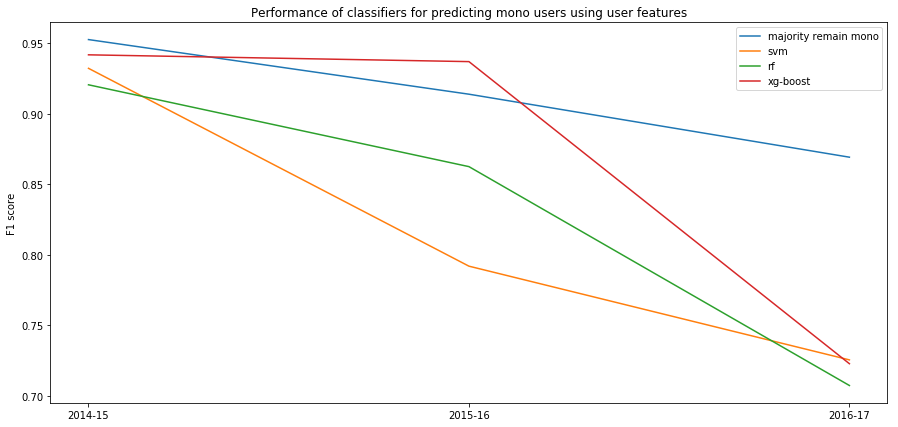

In [276]:
## overssampling 
svm = [ele[0] for ele in svm_scores]
rf = [ele[0] for ele in rf_scores]
xgb = [ele[0] for ele in xgb_scores]
# lstm = [ele[1] for ele in lstm_scores]
maj_score_pos = [ele for ele in maj_scores_pos]
maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,maj_score_pos,label="majority all change to poly")
plt.plot(years,maj_score_neg,label="majority remain mono")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting mono users using user features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

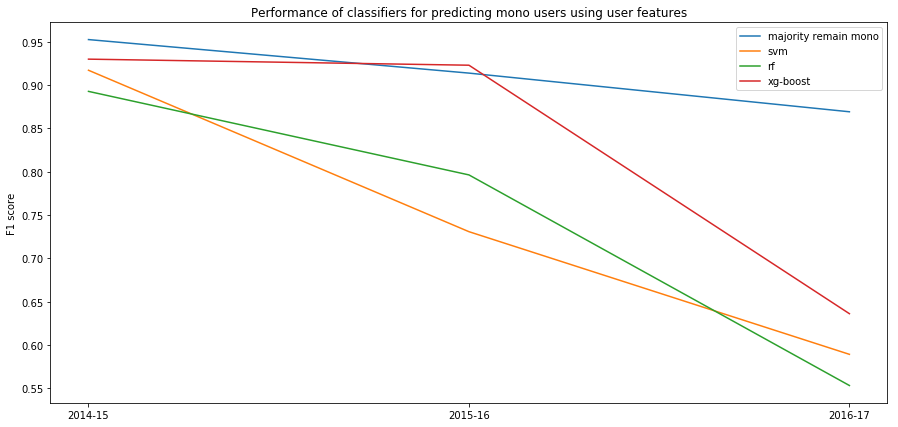

In [279]:
svm = [ele[1] for ele in svm_scores]
rf = [ele[1] for ele in rf_scores]
xgb = [ele[1] for ele in xgb_scores]
# lstm = [ele[1] for ele in lstm_scores]
maj_score_pos = [ele for ele in maj_scores_pos]
maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,maj_score_pos,label="majority all change to poly")
plt.plot(years,maj_score_neg,label="majority remain mono")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting mono users using user features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

In [257]:
maj_pos_scores

[0.0, 0.0, 0.0]

/home/drew_william2345/anaconda3/envs/multimodal-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


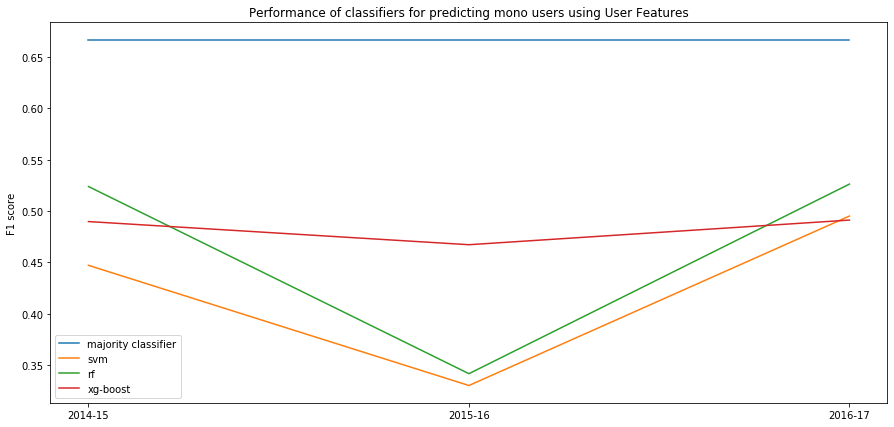

In [38]:
svm = [ele[0] for ele in svm_scores]
rf = [ele[0] for ele in rf_scores]
xgb = [ele[0] for ele in xgb_scores]
# lstm = [ele[0] for ele in lstm_scores]
y_pred_maj = [0 for x in range(len(Y_test))]
maj_score = precision_recall_fscore_support(Y_test,y_pred_maj,average=None)[2][0]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,3*[maj_score],label="majority classifier")
plt.plot(years,svm,label="svm")
# plt.plot(years,lstm,label="lstm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting mono users using User Features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

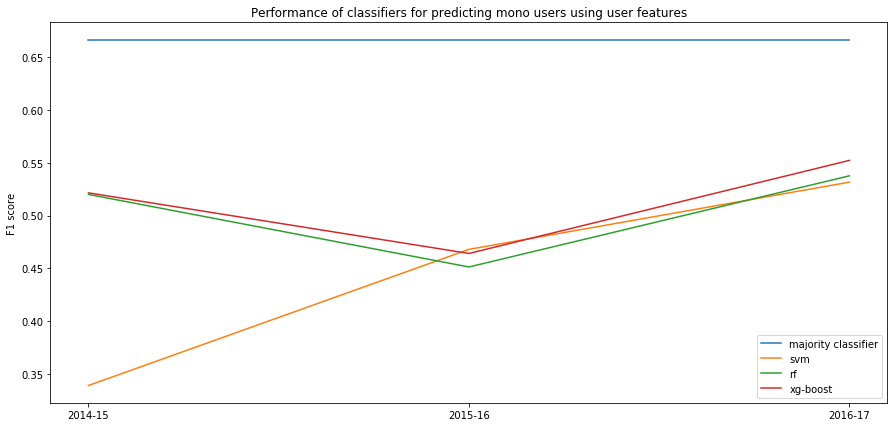

In [39]:
svm = [ele[1] for ele in svm_scores]
rf = [ele[1] for ele in rf_scores]
xgb = [ele[1] for ele in xgb_scores]
# lstm = [ele[1] for ele in lstm_scores]
y_pred_maj = [0 for x in range(len(Y_test))]
maj_score = precision_recall_fscore_support(Y_test,y_pred_maj,average=None)[2][0]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,3*[maj_score],label="majority classifier")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting mono users using user features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

## capture user features

In [291]:
svm_scores = []
rf_scores = []
xgb_scores = []
maj_scores = []
for year,data,users_labelled in bucket_data:
    print("************")
    print("preparing the data")
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    print("runnning classfier to get user features")
    all_models = driver.run_user_features(train_data, test_data, Y_train, Y_test,"over")
    
    
    ## user predictions
    svm_scores.append(all_models['svm'][1])
    rf_scores.append(all_models['rf'][1])
    xgb_scores.append(all_models['xgb'][1])


 26%|██▌       | 273/1049 [00:00<00:00, 2724.88it/s]

************
preparing the data



100%|██████████| 1049/1049 [00:00<00:00, 2536.27it/s]

train-test split
runnning classfier to get user features


/Users/akshay.uppal/Desktop/work/twitter_juul/src/preprocess/escalation/preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/Users/akshay.uppal/Desktop/work/twitter_juul/src/preprocess/escalation/preprocessing.py:56: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/anaconda3/envs/metis-2/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


train data length 839
total positives before in train 78
total train data length  1522
total positives after over sampling 761
training the models
X_train shape (1522, 8)
X_test shape (210, 8)
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean [0.68195355 0.5811003 ] 

random_forest
rf cross val score mean [0.7244896  0.71061249] 

xgBoost


/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

xgb corss val score mean [0.86529947 0.8608604 ] 

the best model xgb
baseline scores calculated
************
preparing the data



100%|██████████| 1636/1636 [00:00<00:00, 1968.29it/s]

train-test split
runnning classfier to get user features


/Users/akshay.uppal/Desktop/work/twitter_juul/src/preprocess/escalation/preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/Users/akshay.uppal/Desktop/work/twitter_juul/src/preprocess/escalation/preprocessing.py:56: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/anaconda3/envs/metis-2/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


train data length 1308
total positives before in train 207
total train data length  2202
total positives after over sampling 1101
training the models
X_train shape (2202, 8)
X_test shape (328, 8)
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean [0.68436096 0.64627141] 

random_forest
rf cross val score mean [0.69387112 0.66920739] 

xgBoost


/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

xgb corss val score mean [0.78999859 0.79464818] 

the best model xgb
baseline scores calculated
************
preparing the data



 55%|█████▍    | 22016/40236 [00:13<00:10, 1770.00it/s]


100%|██████████| 40236/40236 [00:24<00:00, 1652.67it/s]

train-test split
runnning classfier to get user features


/Users/akshay.uppal/Desktop/work/twitter_juul/src/preprocess/escalation/preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/Users/akshay.uppal/Desktop/work/twitter_juul/src/preprocess/escalation/preprocessing.py:56: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/anaconda3/envs/metis-2/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


train data length 32188
total positives before in train 7445
total train data length  49486
total positives after over sampling 24743
training the models
X_train shape (49486, 8)
X_test shape (8048, 8)
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean [0.70431981 0.64841852] 

random_forest
rf cross val score mean [0.6998628  0.65864189] 

xgBoost


/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

xgb corss val score mean [0.7082579  0.69652754] 

the best model xgb
baseline scores calculated


/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/home/drew_william2345/anaconda3/envs/multimodal-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


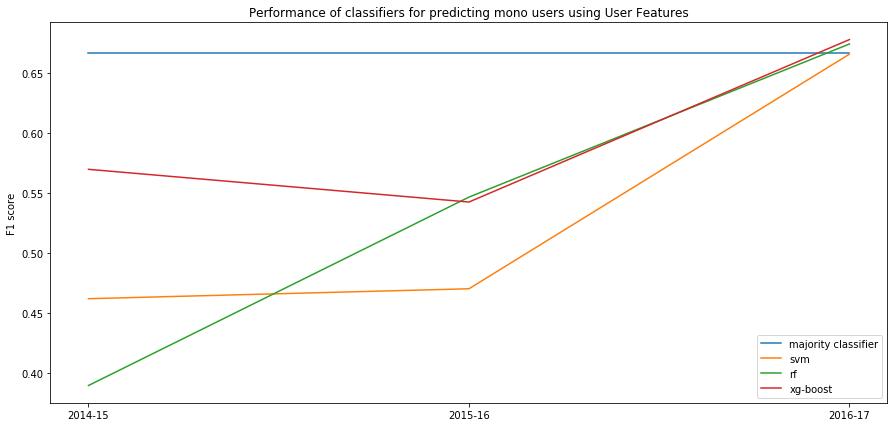

In [30]:
svm = [ele[0] for ele in svm_scores]
rf = [ele[0] for ele in rf_scores]
xgb = [ele[0] for ele in xgb_scores]
y_pred_maj = [0 for x in range(len(Y_test))]
maj_score = precision_recall_fscore_support(Y_test,y_pred_maj,average=None)[2][0]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,3*[maj_score],label="majority classifier")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting mono users using User Features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

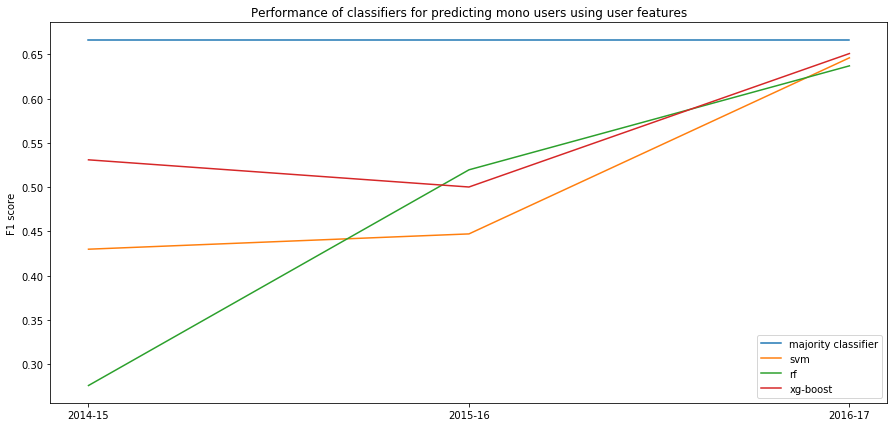

In [31]:
svm = [ele[1] for ele in svm_scores]
rf = [ele[1] for ele in rf_scores]
xgb = [ele[1] for ele in xgb_scores]
y_pred_maj = [0 for x in range(len(Y_test))]
maj_score = precision_recall_fscore_support(Y_test,y_pred_maj,average=None)[2][0]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,3*[maj_score],label="majority classifier")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting mono users using user features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

In [87]:
## using spectral clustering
# clustering = SpectralClustering(n_clusters=100,assign_labels="discretize",random_state=0, n_init=10, n_jobs=-1).fit(X)
# ## all the words are coming into one cluster
# len(cluster_dict[0]) ## 5761

## combining user and text features


100%|██████████| 839/839 [00:00<00:00, 177191.39it/s]

train-test split
max_length 60
preparing the tokenizer
vocalb 4707
creating glove embeddign matrix
encoding the data
X-train (839, 60)
X-test (210, 60)
total train data length  1522
total positives after over sampling 761
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 60)                0         
_________________________________________________________________
embedding_25 (Embedding)     (None, 60, 100)           470700    
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 402       
Total params: 631,902
Trainable params: 631,902
Non-trainable params: 0
_________________________________________________________________
None
f

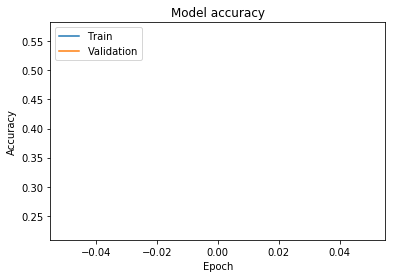

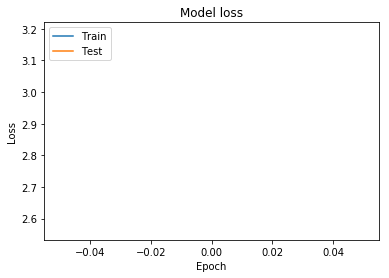

fold = 0
  Classification Report:
              precision    recall  f1-score   support

          0       0.90      0.14      0.24       476
          1       0.48      0.98      0.65       390

avg / total       0.71      0.52      0.42       866
 

Train on 649 samples, validate on 217 samples
Epoch 1/1
649/649 [==============================] - 23s 36ms/step - loss: 1.9889 - acc: 0.6764 - val_loss: 2.4532 - val_acc: 0.0553


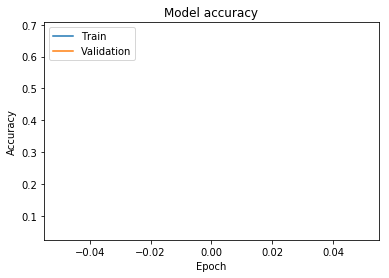

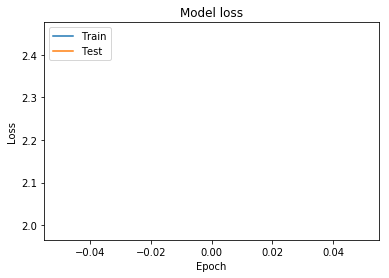

fold = 1
  Classification Report:
              precision    recall  f1-score   support

          0       0.57      1.00      0.73       476
          1       0.97      0.08      0.16       390

avg / total       0.75      0.59      0.47       866
 

*************
0.4833684263297739 0.4015833585862614
training the model with balance dataset
Train on 1141 samples, validate on 381 samples
Epoch 1/1


/Users/akshay.uppal/Desktop/work/twitter_juul/src/preprocess/escalation/driver.py:92: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  verbose=1, batch_size=32, class_weight=weight, )


1141/1141 [==============================] - 41s 36ms/step - loss: 1.1913 - acc: 0.6845 - val_loss: 1.3206 - val_acc: 0.1496


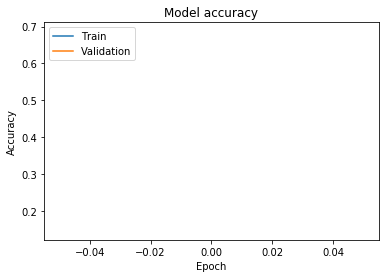

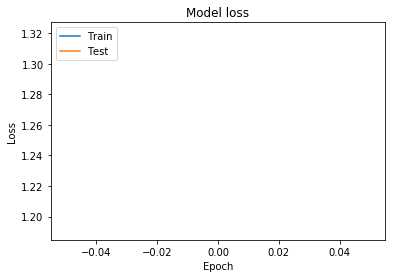

generating classfication report
Accuracy: 90.476191
  Classification Report of train data:
              precision    recall  f1-score   support

          0       0.91      0.99      0.95       191
          1       0.00      0.00      0.00        19

avg / total       0.83      0.90      0.86       210
 

lstm cross val score  0.44247589245801766
job finished
training the models
X_train shape (839, 8)
X_test shape (210, 8)
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean [0.95195868 0.03904762] 

random_forest


/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio

rf cross val score mean [0.95152807 0.        ] 

xgBoost


/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb corss val score mean [0.94318056 0.06262626] 

the best model xgb
baseline scores calculated
train data length 839
total positives before in train 78
total train data length  1522
total positives after over sampling 761
training the models
X_train shape (1522, 100)
X_test shape (210, 100)
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean [0.93224664 0.91720227] 

random_forest
rf cross val score mean [0.92057423 0.89280817] 

xgBoost


/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

xgb corss val score mean [0.94181006 0.93002008] 

the best model xgb
baseline scores calculated


/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [290]:
## preparing the data
dimension = 100
epoch = 1
data_list = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    lstm_scores, lstm_pred, lstm_model, keras_tkzr, max_len= driver.run_lstm(
                                        train_data["tweetText"],test_data["tweetText"],
                                    Y_train, Y_test,dimension,epoch,cross_splits= 2,option="over")
    all_models = driver.run_user_features(train_data, test_data, Y_train, Y_test)
    
    baseline_models, tfidf, svd =  driver.run_text_features(train_data["tweetText"], test_data["tweetText"], 
                                                            Y_train, Y_test)
    
    ## predicting using the ensemble method for all text and user
    data_pred = {'svm_user': all_models["svm"][0], 'rf_user': all_models["rf"][0], 
                 "xgb_user" : all_models["xgb"][0] ,  'lstm': lstm_pred,
                "svm_text":baseline_models["svm"][0], "rf_text":baseline_models["rf"][0],
                "xgb":baseline_models["xgb"][0]}
    
    ## saving the model and configs
    all_models["lstm"] = [lstm_pred,lstm_scores,lstm_model,keras_tkzr,max_len]
    all_models["svm_text"] = baseline_models["svm"]
    all_models["rf_text"] = baseline_models["rf"]
    all_models["xgb_text"] = baseline_models["xgb"]
    all_models["tfidf"] = tfidf
    all_models["svd"] = svd
    
    df_data = pd.DataFrame(data= data_pred)
    data_list.append((test_data,Y_test,df_data,all_models))

### Applying ensembling 

[0.53485125 0.04940957 0.08564474 0.06018534 0.08759014 0.07345726
 0.06082027 0.04804144]


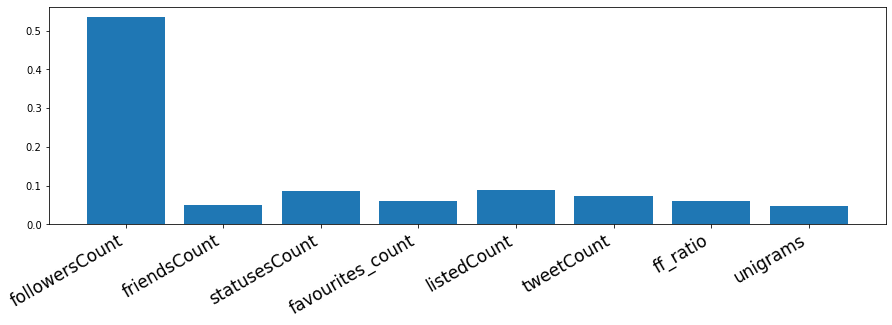

In [523]:
## feature importance for each of the feature
import matplotlib.pyplot as plt
plt.title("feature importance of each of the user features")
print(xgb.feature_importances_)
# plot
plt.figure(figsize=(15,4))
plt.bar(df_test.columns, xgb.feature_importances_)
plt.xticks(rotation='30',ha='right',fontsize=17)
plt.show()

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

In [23]:
ensemble_scores = []
for test_data,Y_test,df_data,all_models in data_list:
    X = df_data.values   ## all model predictions
    y = Y_test
    print("ensemble y val",X.shape)
    print("ensemble y val",len(y))

    lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X,y)
    print(lr.coef_)
    weights = lr.coef_[0]
    print(len(weights))
    #     best_idx = np.argmax(lr.coef_[0])
    ## will use the weighst to make prediction on test set

    ## unpacking all of the models
    _,_,lstm_model,keras_tkzr,max_len = all_models["lstm"]
    _,_,svm_text = all_models["svm_text"]
    _,_,rf_text  = all_models["rf_text"] 
    _,_,xgb_text = all_models["xgb_text"] 
    _,_,svm_user = all_models["svm"]
    _,_,rf_user  = all_models["rf"]
    _,_,xgb_user = all_models["xgb"]
    tfidf = all_models["tfidf"]
    svd  = all_models["svd"] 

    ## getting predicting on test data
    ## text predictions
    lstm_pred = lstm_module.cal_lstm_pred(test_data,Y_test,lstm_model,keras_tkzr,max_len)
    print("lstm prediction",len(lstm_pred))
    
    svm_text_pred = baselines.cal_text_pred(test_data,svm_text,tfidf,svd)
    rf_text_pred = baselines.cal_text_pred(test_data,rf_text,tfidf,svd)
    xgb_text_pred = baselines.cal_text_pred(test_data,xgb_text,tfidf,svd)
    
    ## user predictions
    svm_pred  = baselines.cal_user_pred(test_data, svm_user)
    rf_pred = baselines.cal_user_pred(test_data, rf_user)
    xgb_pred = baselines.cal_user_pred(test_data, xgb_user)


    ## predicting using the ensemble method
    data_pred = {"svm": svm_pred, 
                 "rf": rf_pred, 
                 "xgb" : xgb_pred ,
                 "lstm": lstm_pred , 
                 "svm_text": svm_text_pred,
                 "rf_text":rf_text_pred,
                 "xgb_text":xgb_text_pred,}
    print("data pred length", len(data_pred))
    df_pred = pd.DataFrame(data= data_pred)
    print("pred shape",df_pred.shape)
    X = df_data.values
    y = Y_test
    print("ensemble y test",X.shape)
    print("ensemble y test",len(y))

    # weighted idea
    df_pred = df_pred.mul(list(weights))
    df_pred["pred"] = df_pred.sum(axis=1)  # weighted ensemble
    pred = list(df_pred["pred"])
    
    final_pred = [1 if p >= 0.5 else 0 for p in pred ]  ## threshold as 0.5

    #     df_data["pred"] = df_data.iloc[:,best_idx]  ## selecting based on max weight
    #     print("best index = ",best_idx)
    #     final_pred = list(df_data["pred"])

    print('  Classification Report ensemble:\n',classification_report(Y_test,final_pred),'\n')
    ensemble_score = precision_recall_fscore_support(Y_test,final_pred,average=None)[2]
    ensemble_scores.append(ensemble_score)

ensemble y val (39, 7)
ensemble y val 39
[[-0.33918611  0.24198575  0.57618257 -0.02276761  1.05098192 -0.59243698
   0.10719363]]
7
lstm prediction 39


/home/drew_william2345/anaconda3/envs/multimodal-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/drew_william2345/anaconda3/envs/multimodal-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


data pred length 7
pred shape (39, 7)
ensemble y test (39, 7)
ensemble y test 39
  Classification Report ensemble:
              precision    recall  f1-score   support

          0       0.77      0.85      0.81        20
          1       0.82      0.74      0.78        19

avg / total       0.80      0.79      0.79        39
 

ensemble y val (104, 7)
ensemble y val 104
[[ 0.23010177  0.56645574 -0.4734047  -0.0652903   0.2964038   0.23753672
  -0.1980412 ]]
7
lstm prediction 104


/home/drew_william2345/anaconda3/envs/multimodal-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/drew_william2345/anaconda3/envs/multimodal-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


data pred length 7
pred shape (104, 7)
ensemble y test (104, 7)
ensemble y test 104
  Classification Report ensemble:
              precision    recall  f1-score   support

          0       0.61      0.85      0.71        52
          1       0.75      0.46      0.57        52

avg / total       0.68      0.65      0.64       104
 

ensemble y val (3723, 7)
ensemble y val 3723
[[0.12184216 0.14707508 0.39734555 0.30488122 0.12446216 0.02722193
  0.02980446]]
7
lstm prediction 3723


/home/drew_william2345/anaconda3/envs/multimodal-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


data pred length 7
pred shape (3723, 7)
ensemble y test (3723, 7)
ensemble y test 3723
  Classification Report ensemble:
              precision    recall  f1-score   support

          0       0.63      0.78      0.70      1862
          1       0.72      0.55      0.62      1861

avg / total       0.67      0.66      0.66      3723
 



/home/drew_william2345/anaconda3/envs/multimodal-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


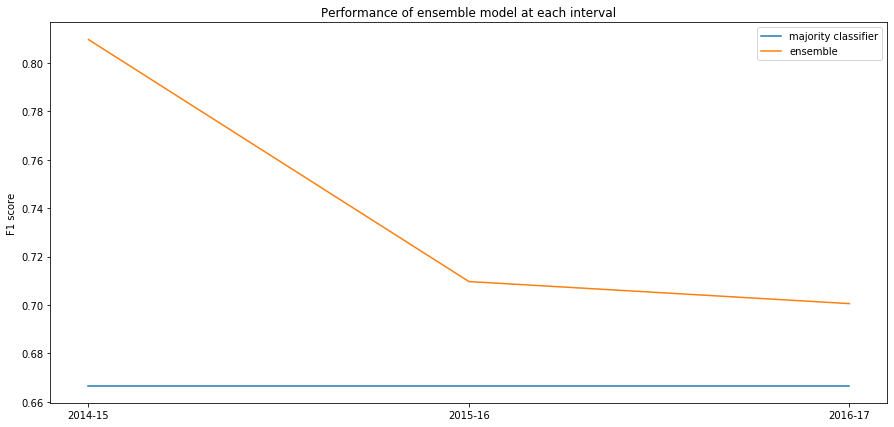

In [27]:
ensemble = [ele[0] for ele in ensemble_scores]
y_pred_maj = [0 for x in range(len(Y_test))]
maj_score = precision_recall_fscore_support(Y_test,y_pred_maj,average=None)[2][0]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,3*[maj_score],label="majority classifier")
plt.plot(years,ensemble,label="ensemble")
plt.title("Performance of ensemble model at each interval")
plt.ylabel("F1 score")
plt.legend()
plt.show()

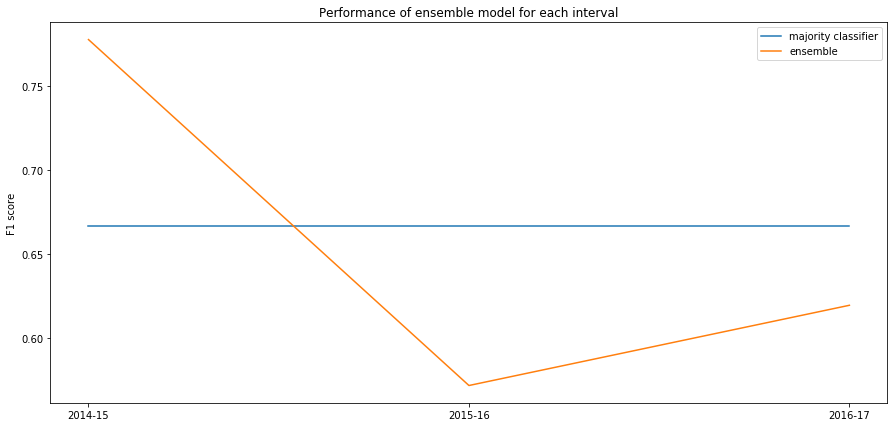

In [28]:
ensemble = [ele[1] for ele in ensemble_scores]

y_pred_maj = [1 for x in range(len(Y_test))]
maj_score = precision_recall_fscore_support(Y_test,y_pred_maj,average=None)[2][1]


## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,3*[maj_score],label="majority classifier")
plt.plot(years,ensemble,label="ensemble")
plt.title("Performance of ensemble model for each interval")
plt.ylabel("F1 score")
plt.legend()
plt.show()

## Sequential prediction using LSTM and baseline classfier for 2018 data

## Month level

In [18]:
## sequence of tweets for user
## output prediction would be for the users so teh lstm layer would need to flatten to a single user..

## poly_turned : if users tweets weed after september (>=9 months) 
## remain_mono :
## seeing the data in different buckets:
#   1  [jan - mar )
#   2  [mar- may )
#   3  [May - july]
#   4  [July - sept]

## use lstm
## use svm
## majority
## xg boost

In [19]:
## so we are taking the users that start on Jan 2018 and change in the month of september, 
# and we change the threshold of input data to see how accurately we can predict that

In [77]:
## input data :juul_data 
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## look at the weed first and juul_first tweet
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
first_data = first_data.loc[first_data.userID.isin(regular_users)]  # reg users
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

In [78]:
## removing the rewteet text column completely
ids_ = juul_data.loc[juul_data['retweetText'].notnull()]["tweetId"]
juul_data.loc[juul_data.tweetId.isin(ids_),"tweetText"] = juul_data.loc[juul_data.tweetId.isin(ids_)]["retweetText"]
juul_data = juul_data.drop(["hashtags","retweetText"],axis=1)
len(juul_data) ## 1353987 (sanity check)

1353987

In [79]:
len(juul_data) ## 1353987
len(juul_data.userID.unique()) ## 673724  reg users

673724

In [292]:
pd.isnull(list(first_data.loc[first_data.userID == 2534]["weed_first"])[0])

True

In [293]:
## get the users who start at jan 2018 
users_2018 = list(first_data["userID"][ 
    (first_data.juul_first.dt.year == 2018)
    & ((first_data.weed_first.dt.year == 2018) | (pd.isnull(first_data.weed_first)))
    & (first_data.juul_first.dt.month== 1)   ## selecting 2018, Jan data
    & (((first_data.weed_first.dt.date) > (first_data.juul_first.dt.date)) | (pd.isnull(first_data.weed_first)))
    & ((first_data.weed_first.dt.month >= 9) | (pd.isnull(first_data.weed_first)))]) # users who will change after september

poly_lbl = list(first_data["userID"].loc[(first_data.juul_first.dt.year == 2018)  
                                        & (first_data.juul_first.dt.month== 1) 
                                        & ((first_data.weed_first.dt.date) > (first_data.juul_first.dt.date))
                                        & ((first_data.weed_first.dt.month >= 9))
                                        & ((first_data.weed_first.dt.year == 2018))
                                        ])
                                            ## users that will change
print("total users", len(users_2018))
print("users will change",len(poly_lbl))


total users 10760
users will change 929


In [294]:
data_2018 = juul_data.loc[juul_data.userID.isin(users_2018) & (juul_data.tweetCreatedAt.dt.year == 2018)]
print("total data", len(data_2018))
print("users",len(data_2018.userID.unique()))

## sanity check -- all users start in 2018 year..
data_2018 = juul_data.loc[juul_data.userID.isin(users_2018)]
print("total data", len(data_2018))
print("users",len(data_2018.userID.unique()))

total data 24018
users 10760
total data 24018
users 10760


In [295]:
## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_2018.userID.unique()
users_labelled = pd.DataFrame(users_,columns=["userID"])
users_labelled["label"] = 0  ## initialize
users_labelled.loc[users_labelled.userID.isin(poly_lbl) , "label"] = 1
len(users_labelled.loc[users_labelled.label == 1])  ## sanity check

929

In [296]:
bucket_data = []

In [297]:
bucket_data.append(preprocessing.get_month_data(data_2018,1,2))
bucket_data.append(preprocessing.get_month_data(data_2018,1,4))
bucket_data.append(preprocessing.get_month_data(data_2018,1,6))
bucket_data.append(preprocessing.get_month_data(data_2018,1,8))

length of the data 13087
total users 10760
length of the data 15477
total users 10760
length of the data 18204
total users 10760
length of the data 20383
total users 10760


********************
length of users 10760
length of the data 13087
users 10760
cleanining the data


max_length 45
window_size 2
preparing the tokenizer
vocalb 6711
creating glove embeddign matrix
encoding the data
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 13087
users before 10760
after data 2410
after users 1858
getting the output label
sequencing data


train-test split
X-train (1114, 2, 45)
X-test (372, 2, 45)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2, 45)             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 2, 45, 100)        671100    
_________________________________________________________________
reshape_3 (Reshape)          (None, 2, 4500)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               3680800   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 402       
Total params: 4,352,302
Trainable params: 4,352,302
Non-trainable params: 0
_________________________________________________________________
None
adjusting the weights for ea

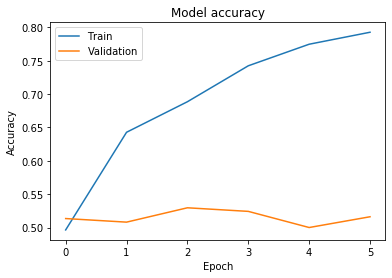

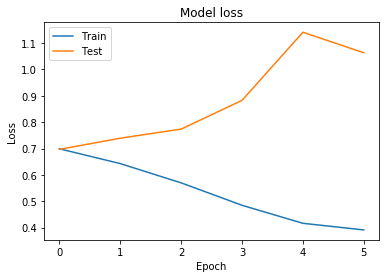

generating classfication report
Accuracy: 53.494624
  Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.50      0.52       186
           1       0.53      0.57      0.55       186

    accuracy                           0.53       372
   macro avg       0.54      0.53      0.53       372
weighted avg       0.54      0.53      0.53       372
 

job finished
********************
length of users 10760
length of the data 15477
users 10760
cleanining the data


max_length 45
window_size 3
preparing the tokenizer
vocalb 7408
creating glove embeddign matrix
encoding the data
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 15477
users before 10760
after data 3021
after users 1858
getting the output label
sequencing data


train-test split
X-train (1114, 3, 45)
X-test (372, 3, 45)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, 45)             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 3, 45, 100)        740800    
_________________________________________________________________
reshape_4 (Reshape)          (None, 3, 4500)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               3680800   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 402       
Total params: 4,422,002
Trainable params: 4,422,002
Non-trainable params: 0
_________________________________________________________________
None
adjusting the weights for ea

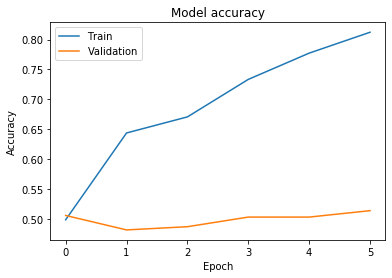

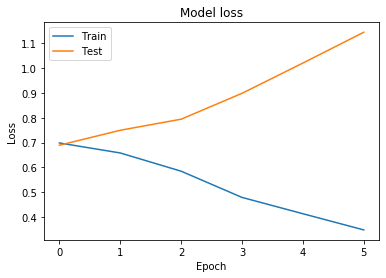

generating classfication report
Accuracy: 51.612903
  Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.41      0.46       186
           1       0.51      0.62      0.56       186

    accuracy                           0.52       372
   macro avg       0.52      0.52      0.51       372
weighted avg       0.52      0.52      0.51       372
 

job finished
********************
length of users 10760
length of the data 18204
users 10760
cleanining the data


max_length 45
window_size 4
preparing the tokenizer
vocalb 8146
creating glove embeddign matrix
encoding the data
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 18204
users before 10760
after data 3767
after users 1858
getting the output label
sequencing data


train-test split
X-train (1114, 4, 45)
X-test (372, 4, 45)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 4, 45)             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 4, 45, 100)        814600    
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4500)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               3680800   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 402       
Total params: 4,495,802
Trainable params: 4,495,802
Non-trainable params: 0
_________________________________________________________________
None
adjusting the weights for ea

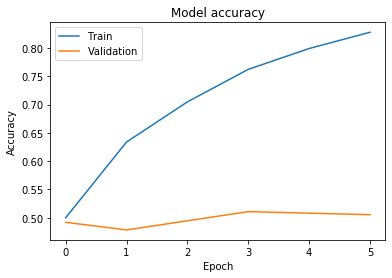

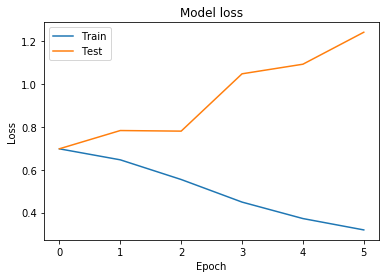

generating classfication report
Accuracy: 47.043011
  Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.49      0.48       186
           1       0.47      0.45      0.46       186

    accuracy                           0.47       372
   macro avg       0.47      0.47      0.47       372
weighted avg       0.47      0.47      0.47       372
 

job finished
********************
length of users 10760
length of the data 20383
users 10760
cleanining the data


max_length 45
window_size 5
preparing the tokenizer
vocalb 8797
creating glove embeddign matrix
encoding the data
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 20383
users before 10760
after data 4389
after users 1858
getting the output label
sequencing data


train-test split
X-train (1114, 5, 45)
X-test (372, 5, 45)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 5, 45)             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 5, 45, 100)        879700    
_________________________________________________________________
reshape_6 (Reshape)          (None, 5, 4500)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               3680800   
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 402       
Total params: 4,560,902
Trainable params: 4,560,902
Non-trainable params: 0
_________________________________________________________________
None
adjusting the weights for ea

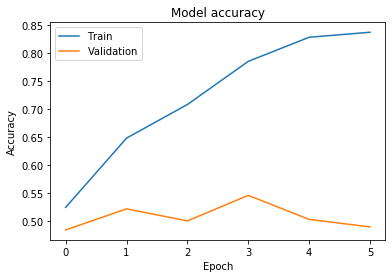

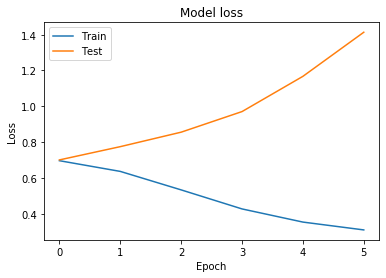

generating classfication report
Accuracy: 51.881720
  Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.38      0.44       186
           1       0.51      0.66      0.58       186

    accuracy                           0.52       372
   macro avg       0.52      0.52      0.51       372
weighted avg       0.52      0.52      0.51       372
 

job finished


In [63]:
## user features
svm_scores = []
rf_scores = []
xgb_scores = []
maj_scores = []
for year,data,users_labelled in bucket_data:
    print("************")
    print("preparing the data")
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    print("runnning classfier to get user features")
    all_models = driver.run_user_features(train_data, test_data, Y_train, Y_test,"over")
    
    ## user predictions
    svm_scores.append(all_models['svm'][1])
    rf_scores.append(all_models['rf'][1])
    xgb_scores.append(all_models['xgb'][1])

In [272]:
maj_scores_neg = []
maj_scores_pos = []
for Y_test in Y_tests:
    y_pred_neg = [0 for x in range(len(Y_test))]
    y_pred_pos = [1 for x in range(len(Y_test))]
    print("length of Y_test",len(Y_test))
    print("positives in Y_test", (util.get_postives(Y_test)))
    maj_pos = precision_recall_fscore_support(Y_test,y_pred_pos,average=None)[2][0]
    maj_scores_pos.append(maj_pos)
    maj_neg = precision_recall_fscore_support(Y_test,y_pred_neg,average=None)[2][0]
    maj_scores_neg.append(maj_neg) 

length of Y_test 210
positives in Y_test 19
length of Y_test 328
positives in Y_test 52
length of Y_test 8048
positives in Y_test 1861


/anaconda3/envs/metis-2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
## overssampling 
svm = [ele[0] for ele in svm_scores]
rf = [ele[0] for ele in rf_scores]
xgb = [ele[0] for ele in xgb_scores]
# lstm = [ele[1] for ele in lstm_scores]
maj_score_pos = [ele for ele in maj_scores_pos]
maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,maj_score_pos,label="majority all change to poly")
plt.plot(years,maj_score_neg,label="majority remain mono")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting mono users using user features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

In [ ]:
svm = [ele[1] for ele in svm_scores]
rf = [ele[1] for ele in rf_scores]
xgb = [ele[1] for ele in xgb_scores]
# lstm = [ele[1] for ele in lstm_scores]
maj_score_pos = [ele for ele in maj_scores_pos]
maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,maj_score_pos,label="majority all change to poly")
plt.plot(years,maj_score_neg,label="majority remain mono")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting mono users using user features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

In [229]:
dr = (cleaned_data_list)[3]
dr.loc[dr["tweetText"].apply(get_length) > 70]

,userID,tweetText,label
2,22363298,"i don't exactly know what a JUUL is but it's probably what ur man is putting around my neck ??????;crying in bed bc my cheating husband is brain dead and can't JUUL all over my tiddies anymore 😞; ok but is this what everyone talks about when they say JUUL? i don't know what it is; omg i just expanded the video and saw that u cited the fact that it's JUUL in the text...sorry to ask that redundant clarification before 😞;in the middle of working one of the single worst bar shifts i have ever worked last night, at one point i went to the backyard to hunt down someone who dipped on their tab and some random girl walks up and shoves a charger in my hand and says “CHARGE MY JUUL THXX” my goooooddddd; my ass is a temple i would not sully with a fucking JUUL",1
9,36601913,We will all get punished for juul i just don’t know how or when;I guess the bright side is the juul is very very clean now ... ya we washed our juul;Sometimes ... every so often ... you may find yourself blessed with a miracle when you don’t deserve one. Thing is ... we all need to remember that the universe may be cruel but is also serendipitously merciful. We found the juul.;My mom cleaned my apt but also slurped up all my juul juice.... trade offs,1
10,40020666,"I saw a dude charging a Juul using a Wii's USB port so that's how my Genesis is going;its weird mango chose his tag after that juul pod;I got drunk and bought a Juul last night so that's where I'm at in life;can I get juul to sponsor me for melee;shout out to this kid wearing a ""buchholz high school class of 2019"" shirt at this coffee shop ripping a juul as he counts quarters to buy a small coffee;Tbh I should just run up and steal this kid's juul. Like who is he gonna tattle to?;I know I talk a lot about the first juul rip of the day and how I like the crackle but goddamn it starts the day off right;i bought bootleg juul pods at a store next to my brunch and they're fuego;Just ripped the fattest Juul rip walking past an ABC7 camera so watch for that later",0
32,84390643,"I don’t do Juul. I have Jesus. ;The green light from the great gatsby was from a juul;disrespect is putting chapstick on and then hitting someone else’s juul right after;Yeah sex is cool and all, but have you ever ripped a Juul first thing in the morning?;ur mcm missed the birth of his first child because he was buying juul pods at the gas station across the street;When you rip the juul and hear mama comin down the hall...lmao ;Please bro lemme hit your juul bro please bro just one hit bro cmon bro lemme take a fat rip off your juul bro please bro I need your juul bro please lemme hit that juul bro please just one hit bro please bro I gottta have my juul fix bro please just one hit please bro juul me;what if the green light that gatsby saw across the water was daisy hitting her juul;Overheard in the quad, “yeah man, I almost forget I have a juul when I’m around her.” Ladies and gentlemen, chivalry is far from dead.;I was your juul but you ran out of pods - Rupi Kaur;saw this rando hitting his juul and the bond was made. bringing america together one cloud at a time ;WHY DID MY PARENTS LET ME ON THE INTERNET ALONE WHEN I WAS 8!!!!!! they broke me i didn't have to be like this.. i could be using a juul and listening to post malone with all the locals right now.... this life i live is just so messed up;Is 3 (three) juul hits a valid meal replacement yes or no;them: “you need to have more fruit” me: *gets mango juul pods instead of mint* “that should do it”;the green light from great gatsby was from a juul;The green light from Gatsby was just Daisy’s juul;this dude just hit a weed vape and a juul at the same time and called it a “silicon valley spliff” oh my god;*at thanksgiving dinner Mom: so your bf is a professional jeweler, that’s so interesting Daughter: no he’s a professional juuler Me: rips juul, blows out smoke to form the word “nice”;Today's list: ✅wake up rip juul ✅lip sync to Drake's new album a

In [ ]:
for svm,tf_idf,month in zip(svm_models,tfidf_list,months):
    print(month)
    plot_coeff(20,svm,tf_idf.get_feature_names())

## End

********************
length of users 10760
length of the data 13087
users 10760
cleanining the data


max_length 45
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 13087
users before 10760
after data 2410
after users 1858
preparing the tokenizer
vocalb 2825
creating glove embeddign matrix
encoding the data
X (1858, 45)
y (1858,)
train-test split
X-train (1114, 45)
X-test (372, 45)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 45)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 45, 100)           282500    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 45, 200)           160800    
_________________________________________________________________
flatten_1 (Flatten)          (None, 9000)       

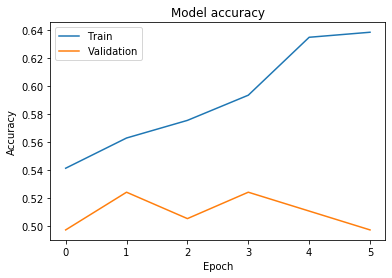

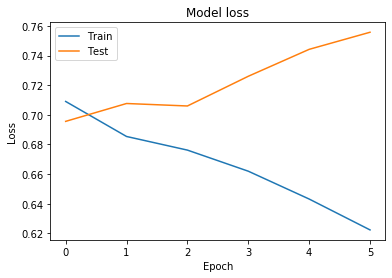

generating classfication report
Accuracy: 59.408602
  Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.52      0.56       186
           1       0.58      0.67      0.62       186

    accuracy                           0.59       372
   macro avg       0.60      0.59      0.59       372
weighted avg       0.60      0.59      0.59       372
 

job finished
********************
length of users 10760
length of the data 15477
users 10760
cleanining the data


max_length 45
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 15477
users before 10760
after data 3021
after users 1858
preparing the tokenizer
vocalb 3254
creating glove embeddign matrix
encoding the data
X (1858, 45)
y (1858,)
train-test split
X-train (1114, 45)
X-test (372, 45)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 45)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 45, 100)           325400    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 45, 200)           160800    
_________________________________________________________________
flatten_2 (Flatten)          (None, 9000)       

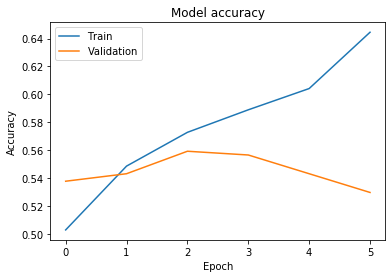

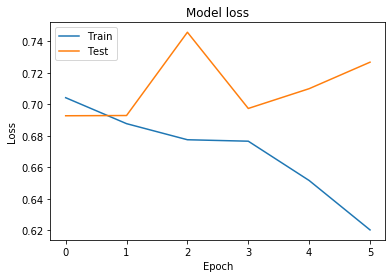

generating classfication report
Accuracy: 56.720430
  Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.48      0.53       186
           1       0.56      0.65      0.60       186

    accuracy                           0.57       372
   macro avg       0.57      0.57      0.56       372
weighted avg       0.57      0.57      0.56       372
 

job finished
********************
length of users 10760
length of the data 18204
users 10760
cleanining the data


max_length 45
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 18204
users before 10760
after data 3767
after users 1858
preparing the tokenizer
vocalb 3753
creating glove embeddign matrix
encoding the data
X (1858, 45)
y (1858,)
train-test split
X-train (1114, 45)
X-test (372, 45)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 45)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 45, 100)           375300    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 45, 200)           160800    
_________________________________________________________________
flatten_3 (Flatten)          (None, 9000)       

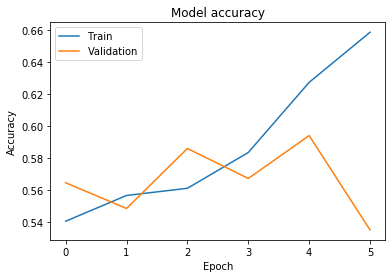

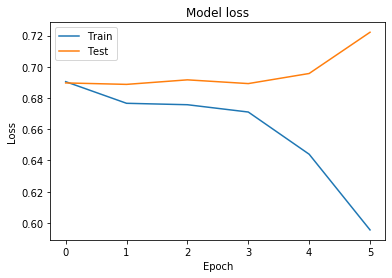

generating classfication report
Accuracy: 61.021505
  Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.56      0.59       186
           1       0.60      0.66      0.63       186

    accuracy                           0.61       372
   macro avg       0.61      0.61      0.61       372
weighted avg       0.61      0.61      0.61       372
 

job finished
********************
length of users 10760
length of the data 20383
users 10760
cleanining the data


max_length 45
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 20383
users before 10760
after data 4389
after users 1858
preparing the tokenizer
vocalb 4151
creating glove embeddign matrix
encoding the data
X (1858, 45)
y (1858,)
train-test split
X-train (1114, 45)
X-test (372, 45)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 45)                0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 45, 100)           415100    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 45, 200)           160800    
_________________________________________________________________
flatten_4 (Flatten)          (None, 9000)       

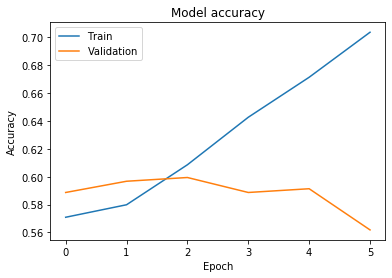

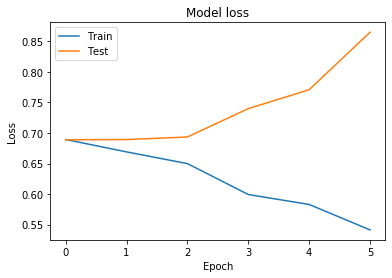

generating classfication report
Accuracy: 58.870968
  Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.41      0.50       186
           1       0.57      0.77      0.65       186

    accuracy                           0.59       372
   macro avg       0.60      0.59      0.57       372
weighted avg       0.60      0.59      0.57       372
 

job finished


In [65]:
## without sequencing lstm
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")
lstm_scores = []
lstm_models = []
cleaned_data_list = []
for data in bucket_data:
    print("********************")
    print("length of users",len(users_labelled))
    df,X,y,embedding_matrix,max_len,vocalb_size  = prepare_data_lstm(data,users_labelled)
    model,score = run_lstm_model(X,y,embedding_matrix,max_len,vocalb_size,dimension=100,epoch= 6,metrics=metrics)
    lstm_scores.append(score)
    lstm_models.append(model)
    cleaned_data_list.append(df)

In [777]:
## dump the scores
# with open(os.path.join(input_dir,"sequence_score.pkl"),"wb") as f:
#     pickle.dump(sequence_scores,f)

# with open(os.path.join(input_dir,"sequence_models.pkl"),"wb") as f:
#     pickle.dump(sequence_models,f)
    
# with open(os.path.join(input_dir,"svm_models.pkl"),"wb") as f:
#     pickle.dump(svm_models,f)

# with open(os.path.join(input_dir,"tf_idfs.pkl"),"wb") as f:
#     pickle.dump(tfidf_list,f)

In [526]:
sequence_scores = pickle.load(open(os.path.join(input_dir,"sequence_score.pkl"),"rb"))

## Sequence models

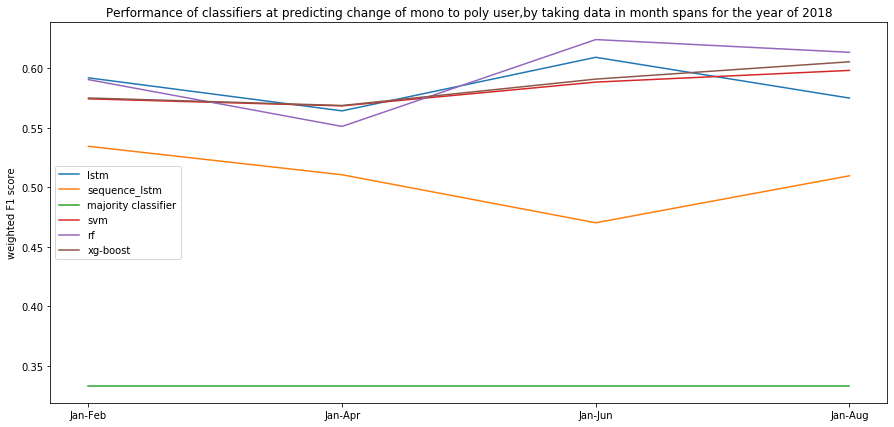

In [67]:
svm = [ele[0] for ele in svm_scores]
rf = [ele[0] for ele in rf_scores]
xgb = [ele[0] for ele in xgb_scores]
y_pred_maj = [0 for x in range(len(Y_test))]
maj_score = precision_recall_fscore_support(Y_test,y_pred_maj,average=None)[2][0]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,3*[maj_score],label="majority classifier")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting mono users using User Features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

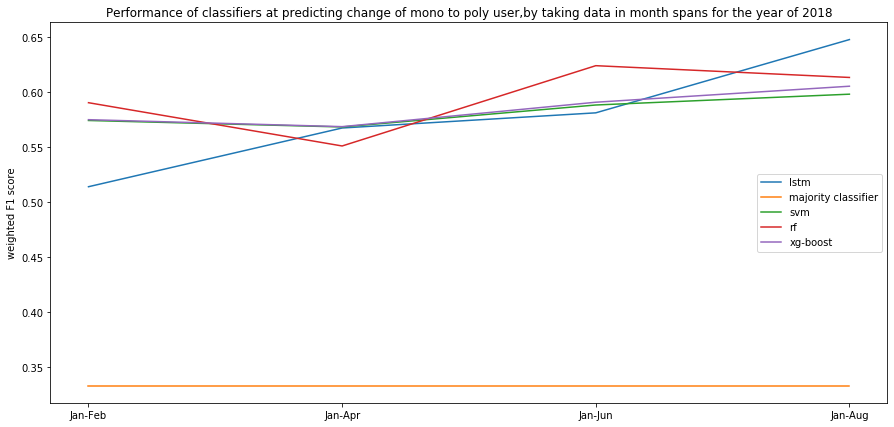

In [135]:
svm = [ele[1] for ele in svm_scores]
rf = [ele[1] for ele in rf_scores]
xgb = [ele[1] for ele in xgb_scores]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,3*[maj_score],label="majority classifier")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting mono users using User Features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

********************
year 2015
length of users 1049
length of the data 2944
users 1049
cleanining the data


max_length 16
window_size 8
preparing the tokenizer
vocalb 5653
creating glove embeddign matrix
encoding the data
total users before 1049
length of positive samples before 97
length of positive samples after 97
total users after 194
before data 2944
users before 1049
after data 727
after users 194
getting the output label
sequencing data


train-test split
X-train (116, 8, 16)
X-test (39, 8, 16)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 8, 16)             0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 8, 16, 100)        565300    
_________________________________________________________________
reshape_10 (Reshape)         (None, 8, 1600)           0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 200)               1360800   
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 402       
Total params: 1,926,502
Trainable params: 1,926,502
Non-trainable params: 0
_________________________________________________________________
None
adjusting the weights for each

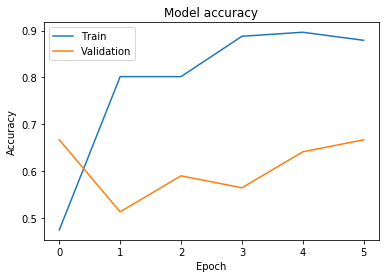

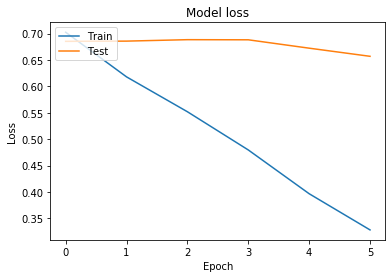

generating classfication report
Accuracy: 53.846154
  Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.50      0.53        20
           1       0.52      0.58      0.55        19

    accuracy                           0.54        39
   macro avg       0.54      0.54      0.54        39
weighted avg       0.54      0.54      0.54        39
 

job finished
********************
year 2016
length of users 1636
length of the data 6475
users 1636
cleanining the data


max_length 17
window_size 10
preparing the tokenizer
vocalb 7226
creating glove embeddign matrix
encoding the data
total users before 1636
length of positive samples before 259
length of positive samples after 259
total users after 518
before data 6475
users before 1636
after data 2386
after users 518
getting the output label
sequencing data


train-test split
X-train (310, 10, 17)
X-test (104, 10, 17)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 10, 17)            0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 10, 17, 100)       722600    
_________________________________________________________________
reshape_11 (Reshape)         (None, 10, 1700)          0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 200)               1440800   
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 402       
Total params: 2,163,802
Trainable params: 2,163,802
Non-trainable params: 0
_________________________________________________________________
None
adjusting the weights for e

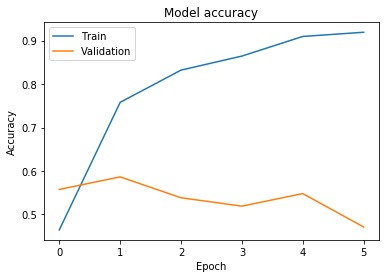

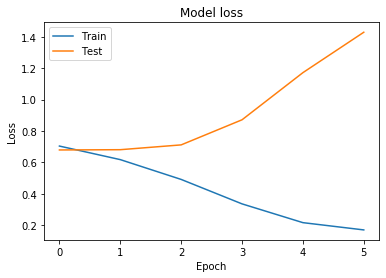

generating classfication report
Accuracy: 52.884615
  Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.40      0.46        52
           1       0.52      0.65      0.58        52

    accuracy                           0.53       104
   macro avg       0.53      0.53      0.52       104
weighted avg       0.53      0.53      0.52       104
 

job finished
********************
year 2017
length of users 40236
length of the data 111735
users 40236
cleanining the data


max_length 27
window_size 9
preparing the tokenizer
vocalb 20598
creating glove embeddign matrix
encoding the data
total users before 40236
length of positive samples before 9306
length of positive samples after 9306
total users after 18612
before data 111735
users before 40236
after data 62085
after users 18612
getting the output label
sequencing data


train-test split
X-train (11166, 9, 27)
X-test (3723, 9, 27)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 9, 27)             0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 9, 27, 100)        2059800   
_________________________________________________________________
reshape_12 (Reshape)         (None, 9, 2700)           0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 200)               2240800   
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 402       
Total params: 4,301,002
Trainable params: 4,301,002
Non-trainable params: 0
_________________________________________________________________
None
adjusting the weights for 

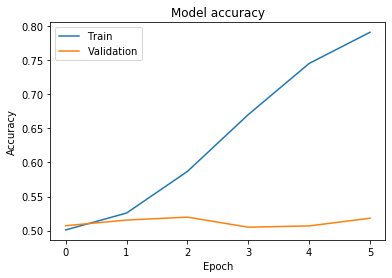

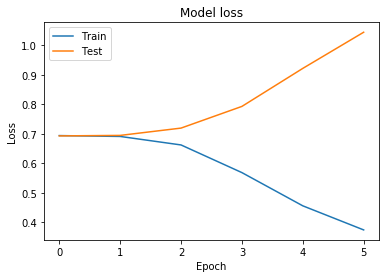

generating classfication report
Accuracy: 50.282031
  Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.46      0.48      1862
           1       0.50      0.55      0.52      1861

    accuracy                           0.50      3723
   macro avg       0.50      0.50      0.50      3723
weighted avg       0.50      0.50      0.50      3723
 

job finished


In [82]:
# will run lstm and other baseline models
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")
sequence_scores = []
sequence_models = []
cleaned_data_list = []
for year,data,users_lbl in bucket_list:
    print("********************")
    print("year",year)
    print("length of users",len(users_lbl))
    df,X,y,embedding_matrix,window,max_len,vocalb_size  = prepare_data_rnn(data,users_lbl)
    model,score = run_sequence_model(X,y,embedding_matrix,window,max_len,vocalb_size,epoch= 6,metrics=metrics)
    sequence_scores.append(score)
    sequence_models.append(model)
    cleaned_data_list.append(df)

In [ ]:
## without sequencing
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")
lstm_scores = []
lstm_models = []
cleaned_data_list = []
for year,data,users_lbl in bucket_list:
    print("********************")
    print("year",year)
    print("length of users",len(users_lbl))
    df,X,y,embedding_matrix,max_len,vocalb_size  = prepare_data_lstm(data,users_lbl)
    model,score = run_lstm_model(X,y,embedding_matrix,max_len,vocalb_size,dimension=100,epoch= 6,metrics=metrics)
    lstm_scores.append(score)
    lstm_models.append(model)
    cleaned_data_list.append(df)

********************
year 2015
length of users 1049
length of the data 2944
users 1049
cleanining the data


max_length 16
total users before 1049
length of positive samples before 97
length of positive samples after 97
total users after 194
before data 2944
users before 1049
after data 727
after users 194
preparing the tokenizer
vocalb 2393
creating glove embeddign matrix


#### basline models

In [ ]:
svm_scores = []
svm_models= []
rf_models= []
rf_scores = []
maj_scores = []
tfidf_list = []
xgb_scores = []
xgb_models = []
for year,data,users_lbl in bucket_list:
    print("********************")
    print("year",year)
    print("length of users",len(users_lbl))
    final = run_baslines(data,users_lbl,)
    svm_model,svm_score = final["svm"]
    rf_model, rf_score = final["rf"]
    xgb_model,xgb_score = final["xg_boost"]
    tf_idf = final["tf-idf"]
    maj_score = final["maj"]
    tfidf_list.append(tf_idf)
    svm_scores.append(svm_score)
    svm_models.append(svm_model)
    rf_scores.append(rf_score)
    rf_models.append(rf_model)
    xgb_scores.append(xgb_score)
    xgb_models.append(xgb_model)
    maj_scores.append(maj_score)

In [ ]:
### plot for sequence scores
plt.figure(figsize=(15,7))
spans = ["2014-15","2015-16","2016-17"]
plt.plot(spans,lstm_scores,label="lstm")
plt.plot(spans,sequence_scores,label="sequence_lstm")
plt.plot(spans,(3*[maj_score]),label="majority classifier")
plt.plot(spans,svm_scores,label="svm")
plt.plot(spans,rf_scores,label="rf")
plt.plot(spans,xgb_scores,label="xg_boost")
plt.title("looking at performcnce of classfiers on different range year data(downsampled)")
plt.ylabel("weighted F1 score")
plt.legend()
plt.show()

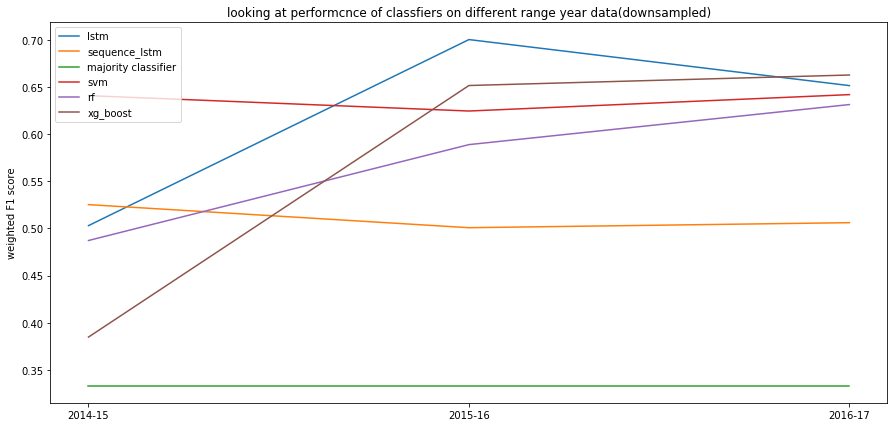

In [77]:
### plot for sequence scores
plt.figure(figsize=(15,7))
spans = ["2014-15","2015-16","2016-17"]
plt.plot(spans,lstm_scores,label="lstm")
plt.plot(spans,sequence_scores,label="sequence_lstm")
plt.plot(spans,(3*[maj_score]),label="majority classifier")
plt.plot(spans,svm_scores,label="svm")
plt.plot(spans,rf_scores,label="rf")
plt.plot(spans,xgb_scores,label="xg_boost")
plt.title("looking at performcnce of classfiers on different range year data(downsampled)")
plt.ylabel("weighted F1 score")
plt.legend()
plt.show()

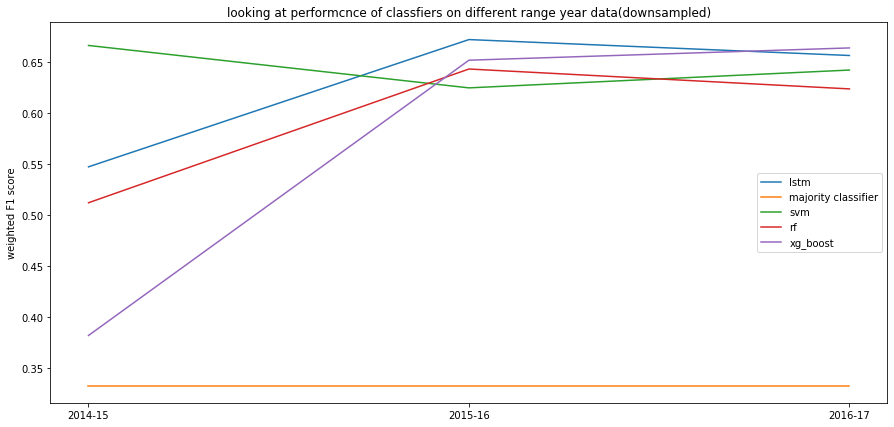

In [91]:
### plot for sequence scores
plt.figure(figsize=(15,7))
spans = ["2014-15","2015-16","2016-17"]
plt.plot(spans,lstm_scores,label="lstm")
plt.plot(spans,(3*[maj_score]),label="majority classifier")
plt.plot(spans,svm_scores,label="svm")
plt.plot(spans,rf_scores,label="rf")
plt.plot(spans,xgb_scores,label="xg_boost")
plt.title("looking at performcnce of classfiers on different range year data(downsampled)")
plt.ylabel("weighted F1 score")
plt.legend()
plt.show()

In [ ]:
## most descriptive words by year
for svm,tf_idf,year in zip(svm_models,tfidf_list,spans):
    print(year)
    plot_coeff(20,svm,tf_idf.get_feature_names())

### looking at cumulative range of data

In [92]:
bucket_list = []
## bucket 1
## 2014 -15 --
year = 2015
print("year",year)
users_ = list(first_data["userID"].loc[ 
    ((first_data.juul_first.dt.year <= year))
    & ((first_data.weed_first.dt.year == (year + 1)) | (pd.isnull(first_data.weed_first))) ## weed data after 2015
            ]) # users who will change after september

poly_turn = list(first_data["userID"].loc[(first_data.juul_first.dt.year <= year)  
                                        & ((first_data.weed_first.dt.year == (year +1 )))]) ## for labelling based on the next year


print("users that will change",len(poly_turn))
print("total users",len(users_))

## getting the input data
data_ = juul_data.loc[juul_data.userID.isin(users_)]
print("length of data",len(data_))

## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_.userID.unique()
users_lbl = pd.DataFrame(users_,columns=["userID"])
users_lbl["label"] = 0  ## initialize
users_lbl.loc[users_lbl.userID.isin(poly_turn) , "label"] = 1
len(users_lbl.loc[users_lbl.label == 1])  ## sanity check
bucket_list.append((year,data_,users_lbl))

year 2015
users that will change 97
total users 1049
length of data 2944


In [93]:
## bucket 1
## 2014 -16 --
year = 2016
print("year",year)
users_ = list(first_data["userID"].loc[ 
    ((first_data.juul_first.dt.year <= year))
    & ((first_data.weed_first.dt.year == (year + 1)) | (pd.isnull(first_data.weed_first))) ## weed data after 2015
            ]) # users who will change after september

poly_turn = list(first_data["userID"].loc[(first_data.juul_first.dt.year <= year)  
                                        & ((first_data.weed_first.dt.year == (year +1 )))]) ## for labelling based on the next year


print("users that will change",len(poly_turn))
print("total users",len(users_))

## getting the input data
data_ = juul_data.loc[juul_data.userID.isin(users_)]
print("length of data",len(data_))

## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_.userID.unique()
users_lbl = pd.DataFrame(users_,columns=["userID"])
users_lbl["label"] = 0  ## initialize
users_lbl.loc[users_lbl.userID.isin(poly_turn) , "label"] = 1
len(users_lbl.loc[users_lbl.label == 1])  ## sanity check
bucket_list.append((year,data_,users_lbl))

year 2016
users that will change 313
total users 2642
length of data 9456


In [94]:
## bucket 1
## 2014 -17 --
year = 2017
print("year",year)
users_ = list(first_data["userID"].loc[ 
    ((first_data.juul_first.dt.year <= year))
    & ((first_data.weed_first.dt.year == (year + 1)) | (pd.isnull(first_data.weed_first))) ## weed data after 2015
            ]) # users who will change after september

poly_turn = list(first_data["userID"].loc[(first_data.juul_first.dt.year <= year)  
                                        & ((first_data.weed_first.dt.year == (year +1 )))]) ## for labelling based on the next year


print("users that will change",len(poly_turn))
print("total users",len(users_))

## getting the input data
data_ = juul_data.loc[juul_data.userID.isin(users_)]
print("length of data",len(data_))

## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_.userID.unique()
users_lbl = pd.DataFrame(users_,columns=["userID"])
users_lbl["label"] = 0  ## initialize
users_lbl.loc[users_lbl.userID.isin(poly_turn) , "label"] = 1
len(users_lbl.loc[users_lbl.label == 1])  ## sanity check
bucket_list.append((year,data_,users_lbl))

year 2017
users that will change 9525
total users 42784
length of data 120873


********************
year 2015
length of users 1049
length of the data 2944
users 1049
cleanining the data



max_length 16
total users before 1049
length of positive samples before 97
length of positive samples after 97
total users after 194
before data 2944
users before 1049
after data 727
after users 194
preparing the tokenizer
vocalb 2393
creating glove embeddign matrix
encoding the data
X (194, 16)
y (194,)
train-test split
X-train (116, 16)
X-test (39, 16)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 16)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 16, 100)           239300    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 16, 200)           160800    
_________________________________________________________________
flatten_5 (Flatten)          (None, 3200)              0   

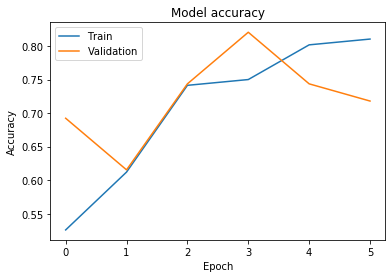

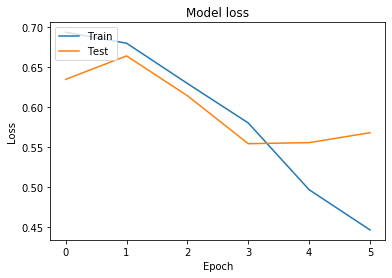

generating classfication report
Accuracy: 58.974359
  Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.75      0.65        20
           1       0.62      0.42      0.50        19

    accuracy                           0.59        39
   macro avg       0.60      0.59      0.58        39
weighted avg       0.60      0.59      0.58        39
 

job finished
********************
year 2016
length of users 2642
length of the data 9456
users 2642
cleanining the data



max_length 17
total users before 2642
length of positive samples before 313
length of positive samples after 313
total users after 626
before data 9456
users before 2642
after data 2878
after users 626
preparing the tokenizer
vocalb 4669
creating glove embeddign matrix
encoding the data
X (626, 17)
y (626,)
train-test split
X-train (375, 17)
X-test (126, 17)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 17)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 17, 100)           466900    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 17, 200)           160800    
_________________________________________________________________
flatten_6 (Flatten)          (None, 3400)              

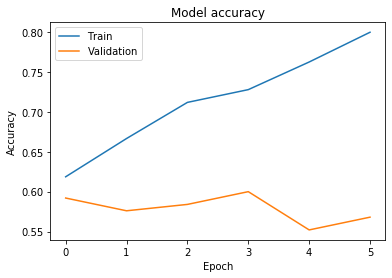

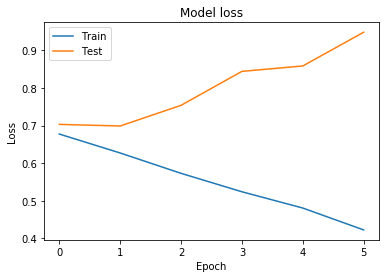

generating classfication report
Accuracy: 65.873016
  Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.73      0.68        63
           1       0.69      0.59      0.63        63

    accuracy                           0.66       126
   macro avg       0.66      0.66      0.66       126
weighted avg       0.66      0.66      0.66       126
 

job finished
********************
year 2017
length of users 42784
length of the data 120873
users 42784
cleanining the data



max_length 26
total users before 42784
length of positive samples before 9525
length of positive samples after 9525
total users after 19050
before data 120873
users before 42784
after data 63890
after users 19050
preparing the tokenizer
vocalb 16490
creating glove embeddign matrix
encoding the data
X (19050, 26)
y (19050,)
train-test split
X-train (11430, 26)
X-test (3810, 26)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 26)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 26, 100)           1649000   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 26, 200)           160800    
_________________________________________________________________
flatten_7 (Flatten)          (None, 

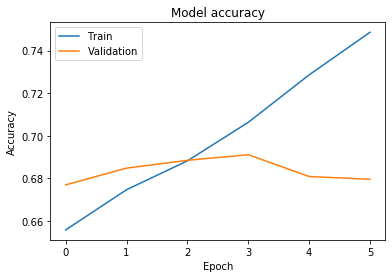

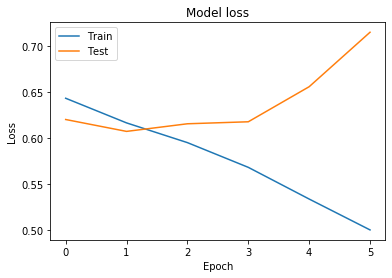

generating classfication report
Accuracy: 66.902887
  Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.71      0.68      1905
           1       0.68      0.63      0.66      1905

    accuracy                           0.67      3810
   macro avg       0.67      0.67      0.67      3810
weighted avg       0.67      0.67      0.67      3810
 

job finished


In [95]:
## RNN (LSTM)
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")
lstm_scores = []
lstm_models = []
cleaned_data_list = []
for year,data,users_lbl in bucket_list:
    print("********************")
    print("year",year)
    print("length of users",len(users_lbl))
    df,X,y,embedding_matrix,max_len,vocalb_size  = prepare_data_lstm(data,users_lbl)
    model,score = run_lstm_model(X,y,embedding_matrix,max_len,vocalb_size,dimension=100,epoch= 6,metrics=metrics)
    lstm_scores.append(score)
    lstm_models.append(model)
    cleaned_data_list.append(df)

#### basline models

In [96]:
svm_scores = []
svm_models= []
rf_models= []
rf_scores = []
maj_scores = []
tfidf_list = []
xgb_scores = []
xgb_models = []
for year,data,users_lbl in bucket_list:
    print("********************")
    print("year",year)
    print("length of users",len(users_lbl))
    final = run_baslines(data,users_lbl,)
    svm_model,svm_score = final["svm"]
    rf_model, rf_score = final["rf"]
    xgb_model,xgb_score = final["xg_boost"]
    tf_idf = final["tf-idf"]
    maj_score = final["maj"]
    tfidf_list.append(tf_idf)
    svm_scores.append(svm_score)
    svm_models.append(svm_model)
    rf_scores.append(rf_score)
    rf_models.append(rf_model)
    xgb_scores.append(xgb_score)
    xgb_models.append(xgb_model)
    maj_scores.append(maj_score)

********************
year 2015
length of users 1049



preparing the tokenizer
downsampling
downsampled data length (194, 5572)
train-test split
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.65      0.65        20
           1       0.63      0.63      0.63        19

    accuracy                           0.64        39
   macro avg       0.64      0.64      0.64        39
weighted avg       0.64      0.64      0.64        39
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50        20
           1       0.47      0.47      0.47        19

    accuracy                           0.49        39
   macro avg       0.49      0.49      0.49        39
weighted avg       0.49      0.49      0.49        39
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.40     


preparing the tokenizer
downsampling
downsampled data length (626, 9745)
train-test split
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.59      0.57        63
           1       0.57      0.54      0.55        63

    accuracy                           0.56       126
   macro avg       0.56      0.56      0.56       126
weighted avg       0.56      0.56      0.56       126
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.86      0.68        63
           1       0.70      0.33      0.45        63

    accuracy                           0.60       126
   macro avg       0.63      0.60      0.57       126
weighted avg       0.63      0.60      0.57       126
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.54     


preparing the tokenizer
downsampling
downsampled data length (19050, 23748)
train-test split
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.71      0.66      1905
           1       0.66      0.57      0.61      1905

    accuracy                           0.64      3810
   macro avg       0.64      0.64      0.64      3810
weighted avg       0.64      0.64      0.64      3810
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.77      0.68      1905
           1       0.68      0.50      0.57      1905

    accuracy                           0.63      3810
   macro avg       0.64      0.63      0.63      3810
weighted avg       0.64      0.63      0.63      3810
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.65  

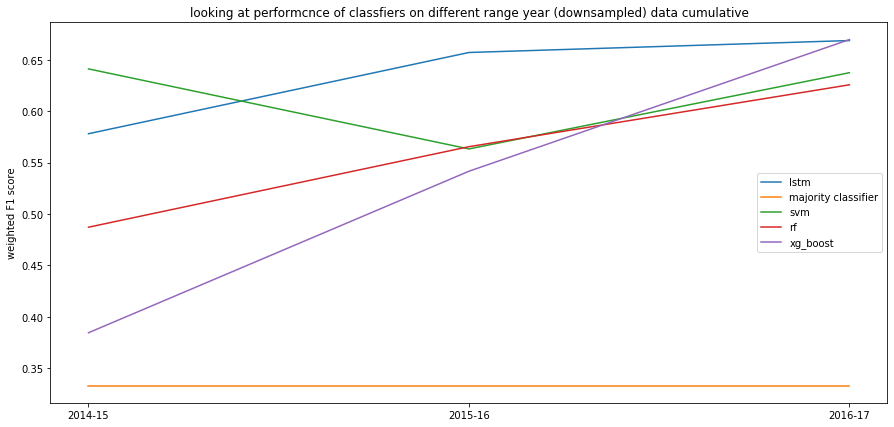

In [97]:
### plot with cumulative data
plt.figure(figsize=(15,7))
spans = ["2014-15","2014-16","2014-17"]
plt.plot(spans,lstm_scores,label="lstm")
plt.plot(spans,(3*[maj_score]),label="majority classifier")
plt.plot(spans,svm_scores,label="svm")
plt.plot(spans,rf_scores,label="rf")
plt.plot(spans,xgb_scores,label="xg_boost")
plt.title("looking at performcnce of classfiers on different range year (downsampled) data cumulative")
plt.ylabel("weighted F1 score")
plt.legend()
plt.show()

In [ ]:
## most descriptive words by year
for svm,tf_idf,year in zip(svm_models,tfidf_list,spans):
    print(year)
    plot_coeff(20,svm,tf_idf.get_feature_names())

In [ ]:
## without downsampling of data
fig, ax = plt.subplots(figsize = (10,6))
x_label = ["2015","205-16","2015-17"]
ax.plot(x_label,lstm_scores,label="lstm")
ax.plot(x_label,svm_scores,label="svm")
ax.plot(x_label,rf_scores,label="rf")
ax.plot(x_label,majority,label="majority classifier")
plt.title("Change of accuarcy of classifier to recongnize mono- > poly on different range of data",fontsize=14)
plt.xlabel("date range",fontsize=12)
plt.ylabel("f1 score of the classifier",fontsize=12)
plt.legend()
plt.show()